In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import random

from google.cloud import storage

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import datasets

from keras.layers import Input, Lambda, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras_tuner
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from keras_tuner.tuners import BayesianOptimization

from numpy import savez_compressed
from numpy import load

from datetime import datetime

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Config

Configuration of important paths.

In [2]:
raw_path = 'data/raw'
split_path = 'data/split'

## Image Augmentation, Normalization & Resizing

### Sample Augmentation - Explore how image augmentation works

Found 542 images belonging to 3 classes.
469


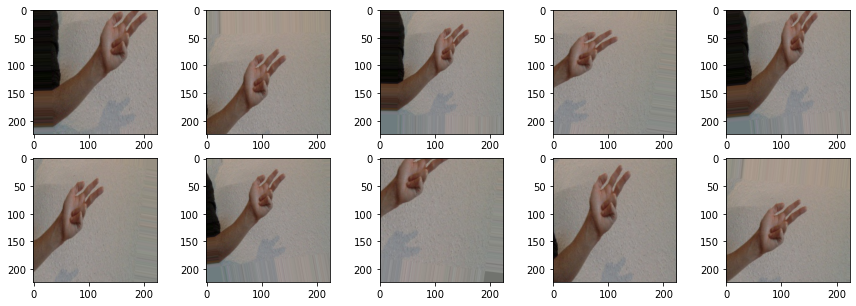

In [3]:
sample_gen = ImageDataGenerator(
    rescale=1./255 ,rotation_range=10, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2
    #brightness_range, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, preprocessing_function=None
)

sample_data = sample_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=1, 
    shuffle=False, 
    seed=1,
    interpolation='nearest'
)

plt.figure(figsize=(15,5))

img = np.random.randint(0, len(sample_data))
print(str(img))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(sample_data[img][0].reshape([224,224,3]))

### Train Image Augmentation

In [4]:
#https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
train_gen = ImageDataGenerator(
    rescale=1./255 #,rotation_range=40, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2
    #brightness_range, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, preprocessing_function=None
)

In [5]:
train_data = train_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)
X_train,y_train = train_data.next()

Found 542 images belonging to 3 classes.


In [6]:
class_names = train_data.class_indices.keys()

### Validation Image Augmentation

In [7]:
val_gen = ImageDataGenerator(rescale=1./255)

val_data = val_gen.flow_from_directory(
    directory = split_path + '/val', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=32, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

#X_val,y_val = val_data.next()

Found 188 images belonging to 3 classes.


# Custom CNN Model

In [8]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), 
                                 padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides = (2,2), padding = 'same'))

model.add(tf.keras.layers.Flatten(name = 'flatten')) 

model.add(tf.keras.layers.Dense(units = 256, activation='relu', name = 'dense1'))

model.add(tf.keras.layers.Dense(units=3, activation='softmax',name = 'output')) 

opt = tf.keras.optimizers.Adam(learning_rate= 0.001) 

model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_categorical_crossentropy'])

2021-11-27 16:48:16.717604: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
model.fit(train_data,
          epochs=5,
          validation_data=val_data)

2021-11-27 16:48:25.626750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
17/17 [==============================] - 66s 4s/step - loss: 34.2856 - accuracy: 0.4520 - sparse_categorical_crossentropy: 34.2856 - val_loss: 0.8839 - val_accuracy: 0.5532 - val_sparse_categorical_crossentropy: 0.8839
Epoch 2/5
17/17 [==============================] - 64s 4s/step - loss: 0.8890 - accuracy: 0.5701 - sparse_categorical_crossentropy: 0.8890 - val_loss: 0.8490 - val_accuracy: 0.6064 - val_sparse_categorical_crossentropy: 0.8490
Epoch 3/5
17/17 [==============================] - 65s 4s/step - loss: 0.7337 - accuracy: 0.6900 - sparse_categorical_crossentropy: 0.7337 - val_loss: 0.6946 - val_accuracy: 0.6649 - val_sparse_categorical_crossentropy: 0.6946
Epoch 4/5
17/17 [==============================] - 64s 4s/step - loss: 0.5949 - accuracy: 0.7417 - sparse_categorical_crossentropy: 0.5949 - val_loss: 0.6885 - val_accuracy: 0.7021 - val_sparse_categorical_crossentropy: 0.6885
Epoch 5/5
17/17 [==============================] - 64s 4s/step - loss: 0.5609 - accuracy: 

In [10]:
model.save('my_model.h5')

## Hyperparameter optimization

In [3]:
def build_cnn(hp):
    ####Config####
    input_pixels = 224
    input_depth = 3
    num_outputs = 3
    ####Config####

    model = tf.keras.Sequential()

    num_inputs = input_pixels
    num_depth = input_depth

    chc_filters_direction = hp.Choice('chc_filters_direction', [0.5, 1.0, 2.0])

    if chc_filters_direction == 0.5:
        num_filters = hp.Choice('num_filters_init', [32, 64])  # [64, 128, 256, 512]
    elif chc_filters_direction == 1.0:
        num_filters = hp.Choice('num_filters_init', [8, 16, 32, 64]) # [32, 64, 128, 256, 512]
    elif chc_filters_direction == 2.0:
        num_filters = hp.Choice('num_filters_init', [8, 16]) # [16, 32, 64, 128]

    num_kernels = hp.Choice('num_kernels', [3, 5]) 

    for b in range(hp.Int('num_blocks', 1, 3)):
      for c in range(hp.Int('num_clayers', 1, 3)):
        model.add(tf.keras.layers.Conv2D(filters= num_filters,
                                        kernel_size= (num_kernels,num_kernels),
                                        strides=(1, 1),
                                        padding='same',
                                        activation='relu', 
                                        input_shape = (num_inputs, num_inputs,num_depth),
                                        name = 'block'+ str(b+1) + '_conv' + str(c+1)))
        num_depth = num_filters 
        
      model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), 
                                          strides = (2,2),
                                          padding = 'same',
                                          name = 'block' + str (b+1) + '_mp'))
      num_inputs = num_inputs / 2 
      num_filters = num_filters * chc_filters_direction

    model.add(tf.keras.layers.Flatten(name = 'flatten')) 

    rate_ddropout = hp.Choice('rate_dlayer_dropout', [0.0,0.25,0.5])

    for d in range(hp.Int('num_dlayers', 0, 3)):
        num_units = hp.Int('num_units_' + str(d+1),min_value=32,max_value=512,step=32)
        model.add(tf.keras.layers.Dense(units = num_units, 
                                        activation='relu',
                                        name = 'dense' + str(d+1)))
        if rate_ddropout > 0.0:
          model.add(tf.keras.layers.Dropout(rate = rate_ddropout,
                                            name = 'dropout' + str(d+1) + '_' + str(rate_ddropout))) 

            
    model.add(tf.keras.layers.Dense(units=num_outputs,
                                    activation='softmax',
                                    name = 'output'))  

    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('rate_learning', [0.01, 0.001, 0.0001])) #hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    #https://www.jeremyjordan.me/nn-learning-rate/
    #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
    model.compile(
        optimizer = opt,
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy'])

    model.summary()

    #hier vllt. eine Art 'Notaus generieren' -> wenn Trainable parameters zu hoch, return schlechtes Modell
    #model.count_params() <- wenn zu groß (muss noch definiert werden - output = input und damit schlecht)

    return model

In [16]:
#cnn_tuner = RandomSearch(build_cnn, #https://keras.io/api/keras_tuner/tuners/random/
#                     objective='val_accuracy',
#                     max_trials=10,
#                     executions_per_trial = 3,
#                     overwrite=True,
#                     project_name='optimization')

#cnn_tuner = Hyperband(build_cnn, #https://keras.io/api/keras_tuner/tuners/hyperband/
#                  objective='val_accuracy',
#                  max_epochs = 5,
#                  factor = 3,
#                  hyperband_iterations = 1, 
#                  project_name='optimization')

cnn_tuner = BayesianOptimization(build_cnn, #https://keras.io/api/keras_tuner/tuners/bayesian/
                             objective='val_accuracy',
                             max_trials=10,
                             executions_per_trial = 1,
                             overwrite=True,
                             project_name='tuning_cnn')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 32)      896       
_________________________________________________________________
block1_mp (MaxPooling2D)     (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
output (Dense)               (None, 3)                 1204227   
Total params: 1,205,123
Trainable params: 1,205,123
Non-trainable params: 0
_________________________________________________________________


In [17]:
cnn_tuner.search_space_summary()

Search space summary
Default search space size: 8
chc_filters_direction (Choice)
{'default': 0.5, 'conditions': [], 'values': [0.5, 1.0, 2.0], 'ordered': True}
num_filters_init (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
num_kernels (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
num_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
num_clayers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
rate_dlayer_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_dlayers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
rate_learning (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [18]:
cnn_tuner.search(train_data,
             epochs=20,
             validation_data=val_data,
             callbacks=[tf.keras.callbacks.TensorBoard('tuning_cnn'),
                        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

Trial 1 Complete [00h 00m 24s]
val_accuracy: 0.3571428656578064

Best val_accuracy So Far: 0.3571428656578064
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit


In [12]:
cnn_tuner.results_summary()

Results summary
Results in ./tuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
chc_filters_direction: 1.0
num_filters_init: 64
num_kernels: 5
num_blocks: 2
num_clayers: 1
rate_dlayer_dropout: 0.25
num_dlayers: 2
rate_learning: 0.001
num_units_1: 32
num_units_2: 32
Score: 0.3571428656578064


In [25]:
model = cnn_tuner.get_best_models(1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 32)      2432      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 32)      25632     
_________________________________________________________________
block1_mp (MaxPooling2D)     (None, 112, 112, 32)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 32)      25632     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 32)      25632     
_________________________________________________________________
block2_mp (MaxPooling2D)     (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

In [2]:
#https://keras.io/guides/keras_tuner/visualize_tuning/

#%load_ext tensorboard
#%reload_ext tensorboard

#%tensorboard --logdir 'tuning_cnn'

#tensorboard --logdir=/optimization --host localhost --port 8088


# Transfer Leaning VGG16 Model

## Hyperparameter optimization

In [8]:
def build_vgg(hp):
    ####Config####
    input_pixels = 224
    input_depth = 3
    num_outputs = 3
    ####Config####

    vgg = VGG16(input_shape=[input_pixels, input_pixels, input_depth], weights='imagenet', include_top=False)

    for layer in vgg.layers:
      layer.trainable = False

    x = vgg.output 
    
    chc_flatten_avgpool = hp.Choice('chc_flatten_or_avgpool', ['flatten', 'pool'])

    if chc_flatten_avgpool == 'flatten':
      x = Flatten()(x)
    elif chc_flatten_avgpool == 'pool':
      x = GlobalAveragePooling2D()(x) # https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras
    
    rate_ddropout = hp.Choice('rate_dlayer_dropout', [0.0,0.25,0.5])

    for d in range(hp.Int('num_dlayers', 0, 2)):
      num_units = hp.Int('num_units_' + str(d+1),min_value=32,max_value=256,step=32)
      x = Dense(num_units, activation='relu', name = 'dense' + str(d+1))(x)

      if rate_ddropout > 0.0:
          Dropout(rate = rate_ddropout, name = 'dropout' + str(d+1) + '_' + str(rate_ddropout))
    
    prediction = Dense(num_outputs, activation='softmax')(x)

    model = Model(inputs=vgg.input, outputs=prediction)

    opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('rate_learning', [0.01, 0.001, 0.0001])) #hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    #https://www.jeremyjordan.me/nn-learning-rate/
    #https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
    model.compile(
        optimizer = opt,
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy', 'sparse_categorical_crossentropy'])

    model.summary()

    return model

In [9]:
#tunvgg_tunerer = RandomSearch(build_cnn, #https://keras.io/api/keras_tuner/tuners/random/
#                     objective='val_accuracy',
#                     max_trials=10,
#                     executions_per_trial = 3,
#                     overwrite=True,
#                     project_name='tuning_vgg')

#vgg_tuner = Hyperband(build_cnn, #https://keras.io/api/keras_tuner/tuners/hyperband/
#                  objective='val_accuracy',
#                  max_epochs = 5,
#                  factor = 3,
#                  hyperband_iterations = 1, 
#                  project_name='tuning_vgg')

vgg_tuner = BayesianOptimization(build_vgg, #https://keras.io/api/keras_tuner/tuners/bayesian/
                                 objective='val_accuracy',
                                 max_trials=10,
                                 executions_per_trial = 1,
                                 overwrite=True,
                                 directory= 'tuning',
                                 project_name='tuning_vgg2')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
vgg_tuner.search_space_summary()

Search space summary
Default search space size: 4
chc_flatten_or_avgpool (Choice)
{'default': 'flatten', 'conditions': [], 'values': ['flatten', 'pool'], 'ordered': False}
rate_dlayer_dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5], 'ordered': True}
num_dlayers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 2, 'step': 1, 'sampling': None}
rate_learning (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
vgg_tuner.search(train_data,
                 epochs=10,
                 validation_data=val_data,
                 callbacks=[tf.keras.callbacks.TensorBoard('tuning_vgg'),
                            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
chc_flatten_or_...|flatten           |?                 
rate_dlayer_dro...|0.5               |?                 
num_dlayers       |1                 |?                 
rate_learning     |0.001             |?                 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1

In [8]:
vgg_tuner.results_summary(3)

Results summary
Results in ./tuning_vgg
Showing 3 best trials
Objective(name='val_accuracy', direction='max')


# Train final model

In [31]:
best_hps = vgg_tuner.get_best_hyperparameters(5)

In [41]:
model = build_vgg(best_hps[0])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [42]:
model.fit(train_data,
          epochs = 1, 
          validation_data = val_data)

17/17 [==============================] - 48s 3s/step - loss: 22.8107 - accuracy: 0.3395 - sparse_categorical_crossentropy: 22.8107 - val_loss: 1.7863 - val_accuracy: 0.5638 - val_sparse_categorical_crossentropy: 1.7863


In [8]:
vgg = VGG16(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

for layer in vgg.layers:
      layer.trainable = False

x = vgg.output 
    
x = Flatten()(x)

prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)


model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_categorical_crossentropy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
model.fit(train_data,
          epochs = 5, 
          validation_data = val_data)

Epoch 1/5
17/17 [==============================] - 292s 17s/step - loss: 0.9684 - accuracy: 0.5849 - sparse_categorical_crossentropy: 0.9684 - val_loss: 0.4921 - val_accuracy: 0.8085 - val_sparse_categorical_crossentropy: 0.4921
Epoch 2/5
17/17 [==============================] - 208s 12s/step - loss: 0.3036 - accuracy: 0.8948 - sparse_categorical_crossentropy: 0.3036 - val_loss: 0.2441 - val_accuracy: 0.9362 - val_sparse_categorical_crossentropy: 0.2441
Epoch 3/5
17/17 [==============================] - 207s 12s/step - loss: 0.1558 - accuracy: 0.9705 - sparse_categorical_crossentropy: 0.1558 - val_loss: 0.1867 - val_accuracy: 0.9521 - val_sparse_categorical_crossentropy: 0.1867
Epoch 4/5
17/17 [==============================] - 207s 12s/step - loss: 0.1067 - accuracy: 0.9871 - sparse_categorical_crossentropy: 0.1067 - val_loss: 0.1459 - val_accuracy: 0.9628 - val_sparse_categorical_crossentropy: 0.1459
Epoch 5/5
17/17 [==============================] - 205s 12s/step - loss: 0.0772 - ac

In [ ]:
# hierbei dann auch noch unbedingt normales callback + finalen Plot erstellen

In [12]:
model.save('models/my_vgg16.h5')

In [11]:
model = tf.keras.models.load_model('models/my_vgg16.h5')

In [ ]:
import shap

In [ ]:
test_gen = ImageDataGenerator(
    rescale=1./255 
)

In [ ]:
classes = os.listdir(split_path + '/test')
if '.DS_Store' in classes:
        classes.remove('.DS_Store')

test_size = 0

for c in classes:
    test_size += len(os.listdir(split_path + '/test/' + c)) - 1

In [ ]:
test_data = test_gen.flow_from_directory(
    directory = split_path + '/test', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=test_size, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

X_test,y_true = test_data.next()
y_true = y_true.astype(int)
y_labels = list(test_data.class_indices.keys())

In [ ]:
background = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)

In [ ]:
shap_values = e.shap_values(X_test[1:5])

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, -X_test[1:5])